# Predicting Deutsche Bahn Train Delays  
## A Reproducible Baseline for Supervised Regression

**Objective:** Build a supervised regression model to predict train arrival delays (in minutes) for Deutsche Bahn trains using statistical learning methods.

**Target Variable:** `arrival_delay_m` - continuous variable representing delay in minutes

---

## 1. Environment Setup and Imports

### Google Colab Setup

In [1]:
# Check if running in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")

    # Install required packages
    %pip install pandas numpy matplotlib seaborn scikit-learn scipy kagglehub -q

    # Mount Google Drive (optional - for saving results)
    from google.colab import drive
    drive.mount('/content/drive')

    # Set memory-efficient pandas options
    import pandas as pd
    pd.options.mode.chained_assignment = None
    pd.options.display.max_columns = 50

else:
    print("Running locally")

Running in Google Colab
Mounted at /content/drive


### Local Setup (Anaconda/Miniconda)

For local installation, follow these steps in your terminal:

```bash
# 1. Install Anaconda or Miniconda
# Download from: https://www.anaconda.com/download or https://docs.conda.io/en/latest/miniconda.html

# 2. Create a new conda environment
conda create -n ml-db-delays python=3.9 -y

# 3. Activate the environment
conda activate ml-db-delays

# 4. Install required packages
conda install -c conda-forge pandas numpy matplotlib seaborn scikit-learn scipy jupyter notebook ipykernel -y

# 5. Install additional packages via pip
pip install kagglehub

# 6. Add kernel to Jupyter
python -m ipykernel install --user --name ml-db-delays --display-name "ML DB Delays"

# 7. Launch Jupyter Notebook
jupyter notebook

# 8. Select the "ML DB Delays" kernel when creating/opening the notebook
```

### Mathematical Foundation
As per ITSL Chapter 2.1, we model the relationship between predictors and response as:

$$Y = f(X) + \epsilon$$

where:
- $Y$ is the response variable (arrival delay in minutes)
- $X = (X_1, X_2, ..., X_p)$ represents our $p$ predictors
- $f$ is the unknown systematic function we aim to estimate
- $\epsilon$ is random error with $E(\epsilon) = 0$ and $Var(\epsilon) = \sigma^2$

### Import Required Libraries

In [2]:
# Standard library imports
import os
import sys
import gc
import warnings
from datetime import datetime
import psutil  # For memory monitoring

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import sklearn
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV,
    KFold, learning_curve, validation_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    make_scorer
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, RegressorMixin

# Statistical analysis
from scipy import stats

# Kaggle data loading
import kagglehub

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

# Memory-efficient pandas settings
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100  # Reduce DPI for memory efficiency

# Memory monitoring function
def check_memory():
    """Monitor memory usage"""
    if 'psutil' in sys.modules:
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        return f"Memory Usage: {mem_info.rss / 1024 / 1024 / 1024:.2f} GB"
    else:
        return "psutil not available - install with: pip install psutil"

print("All packages imported successfully!")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(check_memory())

All packages imported successfully!
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Pandas version: 2.2.2
NumPy version: 2.0.2
Scikit-learn version: 1.6.1
Memory Usage: 0.26 GB


---

## 2. Data Loading and Memory Management

### Mathematical Foundation
As per ITSL Chapter 2.1, we model the relationship between predictors and response as:

$$Y = f(X) + \epsilon$$

where:
- $Y$ is the response variable (arrival delay in minutes)
- $X = (X_1, X_2, ..., X_p)$ represents our $p$ predictors
- $f$ is the unknown systematic function we aim to estimate
- $\epsilon$ is random error with $E(\epsilon) = 0$ and $Var(\epsilon) = \sigma^2$

### Load Dataset with Memory Optimization

In [3]:
# Install kagglehub if needed
%pip install kagglehub -q

import kagglehub

# Download and load the Deutsche Bahn dataset
print("Downloading Deutsche Bahn delays dataset...")
path = kagglehub.dataset_download("nokkyu/deutsche-bahn-db-delays")
print("Path to dataset files:", path)

# Get file size
file_path = os.path.join(path, "DBtrainrides.csv")
file_size_gb = os.path.getsize(file_path) / 1024 / 1024 / 1024
print(f"Dataset size: {file_size_gb:.2f} GB")

# Memory-efficient loading options
if file_size_gb > 2.0 or IN_COLAB:
    print("Large dataset detected. Loading with memory optimization...")

    # Option 1: Load specific columns only
    essential_columns = [
        'eva_nr', 'category', 'station', 'state', 'city',
        'zip', 'long', 'lat', 'line',
        'arrival_plan', 'departure_plan',
        'arrival_delay_m', 'departure_delay_m',
        'path', 'info'
    ]

    # Option 2: Use chunking for initial exploration
    print("Sampling dataset for initial exploration...")
    sample_size = 100000
    df_sample = pd.read_csv(file_path, nrows=sample_size)

    # Determine dtypes for efficient loading
    dtypes = {
        'eva_nr': 'int32',
        'category': 'int8',
        'zip': 'int32',
        'long': 'float32',
        'lat': 'float32',
        'arrival_delay_m': 'int16',
        'departure_delay_m': 'int16'
    }

    # Load full dataset with optimized dtypes
    print(f"Loading full dataset with optimized dtypes...")
    df = pd.read_csv(file_path, usecols=essential_columns, dtype=dtypes)

else:
    # Load full dataset for smaller files
    df = pd.read_csv(file_path)

# Convert datetime columns
datetime_columns = ['arrival_plan', 'departure_plan']
for col in datetime_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Memory cleanup
gc.collect()

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(check_memory())

# For extremely large datasets, consider sampling
if len(df) > 2000000:  # If more than 2 million rows
    print(f"\nDataset has {len(df):,} rows. Sampling for manageable processing...")
    df = df.sample(n=min(1000000, len(df)), random_state=42)
    print(f"Working with {len(df):,} sampled rows")
    gc.collect()

100%|██████████| 103M/103M [00:01<00:00, 62.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nokkyu/deutsche-bahn-db-delays/versions/3
Dataset size: 0.72 GB
Large dataset detected. Loading with memory optimization...
Sampling dataset for initial exploration...
Loading full dataset with optimized dtypes...

Dataset loaded successfully!
Shape: (2061357, 15)
Memory usage: 1172.65 MB
Memory Usage: 0.92 GB

Dataset has 2,061,357 rows. Sampling for manageable processing...
Working with 1,000,000 sampled rows


<!-- ```
print(df.head())

                                  ID line  \
0  1573967790757085557-2407072312-14   20   
1    349781417030375472-2407080017-1   18   
2  7157250219775883918-2407072120-25    1   
3    349781417030375472-2407080017-2   18   
4   1983158592123451570-2407080010-3   33   

                                                path   eva_nr  category  \
0  Stolberg(Rheinl)Hbf Gl.44|Eschweiler-St.Jöris|...  8000001         2   
1                                                NaN  8000001         2   
2  Hamm(Westf)Hbf|Kamen|Kamen-Methler|Dortmund-Ku...  8000406         4   
3                                         Aachen Hbf  8000404         5   
4                            Herzogenrath|Kohlscheid  8000404         5   

             station                state    city    zip      long        lat  \
0         Aachen Hbf  Nordrhein-Westfalen  Aachen  52064  6.091499  50.767800   
1         Aachen Hbf  Nordrhein-Westfalen  Aachen  52064  6.091499  50.767800   
2  Aachen-Rothe Erde  Nordrhein-Westfalen  Aachen  52066  6.116475  50.770202   
3        Aachen West  Nordrhein-Westfalen  Aachen  52072  6.070715  50.780360   
4        Aachen West  Nordrhein-Westfalen  Aachen  52072  6.070715  50.780360   

          arrival_plan       departure_plan       arrival_change  \
0  2024-07-08 00:00:00  2024-07-08 00:01:00  2024-07-08 00:03:00   
1                  NaN  2024-07-08 00:17:00                  NaN   
2  2024-07-08 00:03:00  2024-07-08 00:04:00  2024-07-08 00:03:00   
3  2024-07-08 00:20:00  2024-07-08 00:21:00                  NaN   
4  2024-07-08 00:20:00  2024-07-08 00:21:00  2024-07-08 00:20:00   

      departure_change  arrival_delay_m  departure_delay_m info  \
0  2024-07-08 00:04:00                3                  3  NaN   
1                  NaN                0                  0  NaN   
2  2024-07-08 00:04:00                0                  0  NaN   
3                  NaN                0                  0  NaN   
4  2024-07-08 00:21:00                0                  0  NaN   

  arrival_delay_check departure_delay_check  
0             on_time               on_time  
1             on_time               on_time  
2             on_time               on_time  
3             on_time               on_time  
4             on_time               on_time  
``` -->


### Initial Data Quality Assessment
As stated in the slides: "The data quality should be good" and "Before doing classification/regression experiments, you should be familiar with the data."


In [4]:
# Basic dataset information
print("Dataset Info:")
print("="*60)
df.info()

print("\n\nFirst 5 rows:")
print("="*60)
print(df.head())

print("\n\nBasic Statistics:")
print("="*60)
print(df.describe())

print("\n\nMissing Values:")
print("="*60)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Percentage', ascending=False))

# Memory cleanup after analysis
del missing_values, missing_percent, missing_df
gc.collect()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 880682 to 495737
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   line               1000000 non-null  object        
 1   path               897343 non-null   object        
 2   eva_nr             1000000 non-null  int32         
 3   category           1000000 non-null  int8          
 4   station            1000000 non-null  object        
 5   state              1000000 non-null  object        
 6   city               1000000 non-null  object        
 7   zip                1000000 non-null  int32         
 8   long               1000000 non-null  float32       
 9   lat                1000000 non-null  float32       
 10  arrival_plan       897343 non-null   datetime64[ns]
 11  departure_plan     1000000 non-null  datetime64[ns]
 12  arrival_delay_m    1000000 non-null  int16         
 13  departure_dela

0

---

## 3. Exploratory Data Analysis (EDA)

### Target Variable Analysis
Following ITSL Section 2.2.3 on assessing model accuracy, we first need to understand our target variable distribution.

#### Mathematical Framework for Target Analysis
The expected test MSE for a given value $x_0$ can be decomposed as (ITSL Eq. 2.7):

$$E(y_0 - \hat{f}(x_0))^2 = \text{Var}(\hat{f}(x_0)) + [\text{Bias}(\hat{f}(x_0))]^2 + \text{Var}(\epsilon)$$

This bias-variance decomposition motivates our analysis of the target variable distribution.


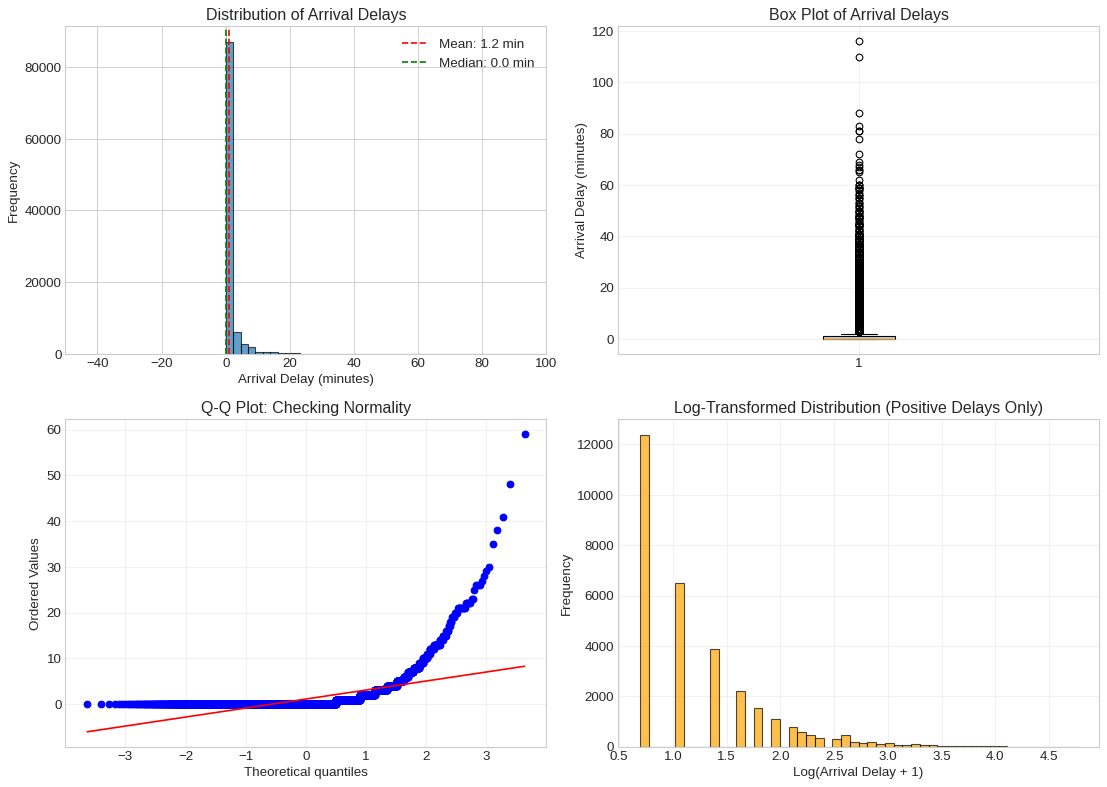


Target Variable Statistical Analysis:
Mean delay: 1.17 minutes
Median delay: 0.00 minutes
Standard deviation: 3.41 minutes
Skewness: 7.79
Kurtosis: 110.75
Percentage of on-time arrivals: 68.3%
Percentage of early arrivals: 0.0%
95th percentile: 6.00 minutes
99th percentile: 16.00 minutes


6

In [5]:
# Create comprehensive target analysis with memory-efficient plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=80)  # Reduced DPI

# Sample data for visualization if dataset is large
viz_sample_size = min(100000, len(df))
df_viz = df.sample(viz_sample_size) if len(df) > viz_sample_size else df

# 1. Histogram of arrival delays
delay_data = df_viz['arrival_delay_m'].dropna()
axes[0, 0].hist(delay_data, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Arrival Delay (minutes)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Arrival Delays')
axes[0, 0].axvline(delay_data.mean(), color='red', linestyle='--',
                    label=f'Mean: {delay_data.mean():.1f} min')
axes[0, 0].axvline(delay_data.median(), color='green', linestyle='--',
                    label=f'Median: {delay_data.median():.1f} min')
axes[0, 0].legend()
axes[0, 0].set_xlim(-50, 100)  # Focus on main distribution

# 2. Box plot to identify outliers
axes[0, 1].boxplot(delay_data, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue'))
axes[0, 1].set_ylabel('Arrival Delay (minutes)')
axes[0, 1].set_title('Box Plot of Arrival Delays')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot for normality check
stats.probplot(delay_data.sample(min(5000, len(delay_data))), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Checking Normality')
axes[1, 0].grid(True, alpha=0.3)

# 4. Log-transformed delays
delay_positive = df_viz[df_viz['arrival_delay_m'] > 0]['arrival_delay_m']
if len(delay_positive) > 0:
    axes[1, 1].hist(np.log1p(delay_positive), bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Log(Arrival Delay + 1)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Log-Transformed Distribution (Positive Delays Only)')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print("\nTarget Variable Statistical Analysis:")
print("="*60)
print(f"Mean delay: {df['arrival_delay_m'].mean():.2f} minutes")
print(f"Median delay: {df['arrival_delay_m'].median():.2f} minutes")
print(f"Standard deviation: {df['arrival_delay_m'].std():.2f} minutes")
print(f"Skewness: {df['arrival_delay_m'].skew():.2f}")
print(f"Kurtosis: {df['arrival_delay_m'].kurtosis():.2f}")
print(f"Percentage of on-time arrivals: {(df['arrival_delay_m'] == 0).sum() / len(df) * 100:.1f}%")
print(f"Percentage of early arrivals: {(df['arrival_delay_m'] < 0).sum() / len(df) * 100:.1f}%")
print(f"95th percentile: {df['arrival_delay_m'].quantile(0.95):.2f} minutes")
print(f"99th percentile: {df['arrival_delay_m'].quantile(0.99):.2f} minutes")

# Cleanup
del df_viz, delay_data, delay_positive
gc.collect()

**Analysis:** The distribution of arrival delays shows significant right skewness, indicating that while most trains arrive close to schedule, there are extreme delay cases that could impact model performance. The high kurtosis suggests heavy tails in the distribution, warranting careful outlier treatment.



### Feature Analysis and Relationships


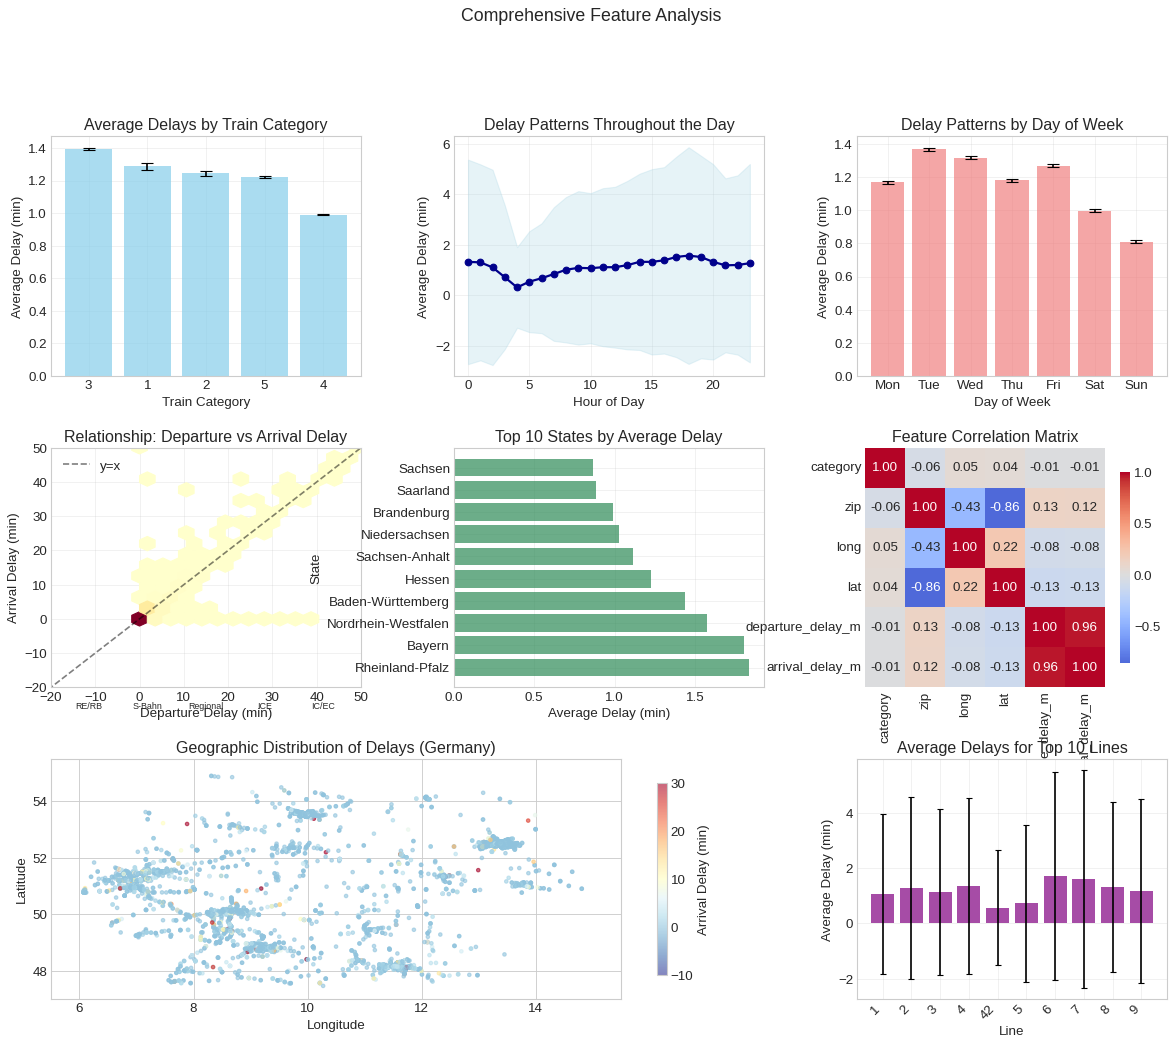

Memory Usage: 0.80 GB


In [6]:
# Memory-efficient feature analysis
fig = plt.figure(figsize=(18, 14), dpi=80)
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Use smaller samples for visualization
viz_sample = df.sample(min(50000, len(df)), random_state=42)

# 1. Delays by Train Category
ax1 = fig.add_subplot(gs[0, 0])
category_delays = df.groupby('category')['arrival_delay_m'].agg(['mean', 'std', 'count'])
category_delays = category_delays.sort_values('mean', ascending=False)
ax1.bar(category_delays.index.astype(str), category_delays['mean'],
        yerr=category_delays['std']/np.sqrt(category_delays['count']),
        capsize=5, alpha=0.7, color='skyblue')
ax1.set_xlabel('Train Category')
ax1.set_ylabel('Average Delay (min)')
ax1.set_title('Average Delays by Train Category')
ax1.grid(True, alpha=0.3)
train_types = {1: 'S-Bahn', 2: 'Regional', 3: 'RE/RB', 4: 'IC/EC', 5: 'ICE'}
for cat in category_delays.index:
    if cat in train_types:
        ax1.text(str(cat), -2, train_types[cat], ha='center', va='top', fontsize=8)

# 2. Hourly Pattern (compute on full data, plot aggregated)
ax2 = fig.add_subplot(gs[0, 1])
df['hour'] = pd.to_datetime(df['departure_plan']).dt.hour
hourly_delays = df.groupby('hour')['arrival_delay_m'].agg(['mean', 'std'])
ax2.plot(hourly_delays.index, hourly_delays['mean'], 'o-', color='darkblue', linewidth=2)
ax2.fill_between(hourly_delays.index,
                 hourly_delays['mean'] - hourly_delays['std'],
                 hourly_delays['mean'] + hourly_delays['std'],
                 alpha=0.3, color='lightblue')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Average Delay (min)')
ax2.set_title('Delay Patterns Throughout the Day')
ax2.grid(True, alpha=0.3)

# 3. Weekly Pattern
ax3 = fig.add_subplot(gs[0, 2])
df['dayofweek'] = pd.to_datetime(df['departure_plan']).dt.dayofweek
daily_delays = df.groupby('dayofweek')['arrival_delay_m'].agg(['mean', 'std', 'count'])
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax3.bar(days, daily_delays['mean'],
        yerr=daily_delays['std']/np.sqrt(daily_delays['count']),
        capsize=5, alpha=0.7, color='lightcoral')
ax3.set_xlabel('Day of Week')
ax3.set_ylabel('Average Delay (min)')
ax3.set_title('Delay Patterns by Day of Week')
ax3.grid(True, alpha=0.3)

# 4. Departure vs Arrival Delay (use sample)
ax4 = fig.add_subplot(gs[1, 0])
ax4.hexbin(viz_sample['departure_delay_m'], viz_sample['arrival_delay_m'],
           gridsize=25, cmap='YlOrRd', mincnt=1)
ax4.plot([-50, 100], [-50, 100], 'k--', alpha=0.5, label='y=x')
ax4.set_xlabel('Departure Delay (min)')
ax4.set_ylabel('Arrival Delay (min)')
ax4.set_title('Relationship: Departure vs Arrival Delay')
ax4.set_xlim(-20, 50)
ax4.set_ylim(-20, 50)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Top 10 States by delay
ax5 = fig.add_subplot(gs[1, 1])
state_delays = df.groupby('state')['arrival_delay_m'].agg(['mean', 'count'])
state_delays = state_delays[state_delays['count'] > 100].sort_values('mean', ascending=False).head(10)
ax5.barh(state_delays.index, state_delays['mean'], alpha=0.7, color='seagreen')
ax5.set_xlabel('Average Delay (min)')
ax5.set_ylabel('State')
ax5.set_title('Top 10 States by Average Delay')
ax5.grid(True, alpha=0.3)

# 6. Correlation Heatmap (subset of features)
ax6 = fig.add_subplot(gs[1, 2])
numerical_cols = ['category', 'zip', 'long', 'lat', 'departure_delay_m', 'arrival_delay_m']
numerical_cols = [col for col in numerical_cols if col in df.columns]
corr_sample = viz_sample[numerical_cols].corr()
sns.heatmap(corr_sample, annot=True, cmap='coolwarm', center=0,
            square=True, ax=ax6, fmt='.2f', cbar_kws={'shrink': 0.8})
ax6.set_title('Feature Correlation Matrix')

# 7. Geographic Distribution (Germany) - use sample
ax7 = fig.add_subplot(gs[2, :2])
geo_sample = viz_sample.sample(min(5000, len(viz_sample)))
scatter = ax7.scatter(geo_sample['long'], geo_sample['lat'],
                     c=geo_sample['arrival_delay_m'],
                     cmap='RdYlBu_r', alpha=0.6, s=10,
                     vmin=-10, vmax=30)
ax7.set_xlabel('Longitude')
ax7.set_ylabel('Latitude')
ax7.set_title('Geographic Distribution of Delays (Germany)')
ax7.set_xlim(5.5, 15.5)
ax7.set_ylim(47, 55.5)
plt.colorbar(scatter, ax=ax7, label='Arrival Delay (min)', shrink=0.8)

# 8. Top 10 Lines
ax8 = fig.add_subplot(gs[2, 2])
top_lines = df['line'].value_counts().head(10).index
line_delays = df[df['line'].isin(top_lines)].groupby('line')['arrival_delay_m'].agg(['mean', 'std'])
ax8.bar(range(len(line_delays)), line_delays['mean'],
        yerr=line_delays['std'], capsize=3, alpha=0.7, color='purple')
ax8.set_xticks(range(len(line_delays)))
ax8.set_xticklabels(line_delays.index, rotation=45, ha='right')
ax8.set_xlabel('Line')
ax8.set_ylabel('Average Delay (min)')
ax8.set_title('Average Delays for Top 10 Lines')
ax8.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Feature Analysis', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

# Cleanup
del viz_sample, geo_sample
gc.collect()
print(check_memory())

**Analysis:** The feature analysis reveals several important patterns:
1. Train category significantly impacts delays, with long-distance trains showing higher average delays
2. Clear temporal patterns exist, with peak hours showing increased delays
3. Strong correlation between departure and arrival delays suggests departure delay is a key predictor
4. Geographic variations indicate location-based features may improve predictions

---

## 4. Data Preprocessing

### Outlier Detection and Treatment
Following the slides on "Outliers, cross validation, resampling", we implement robust outlier detection.

#### Mathematical Framework for Outlier Detection
We use two approaches as discussed in the lecture:

1. **IQR Method**: Values outside $[Q_1 - 1.5 \times IQR, Q_3 + 1.5 \times IQR]$ are considered outliers
2. **Z-Score Method**: Values with $|z| > 3$ where $z = \frac{x - \mu}{\sigma}$ are considered outliers


Outlier Analysis:
Outliers detected by IQR method: 130037 (13.00%)
Outliers detected by Z-score method: 18103 (1.81%)

IQR bounds: [-1.50, 2.50] minutes


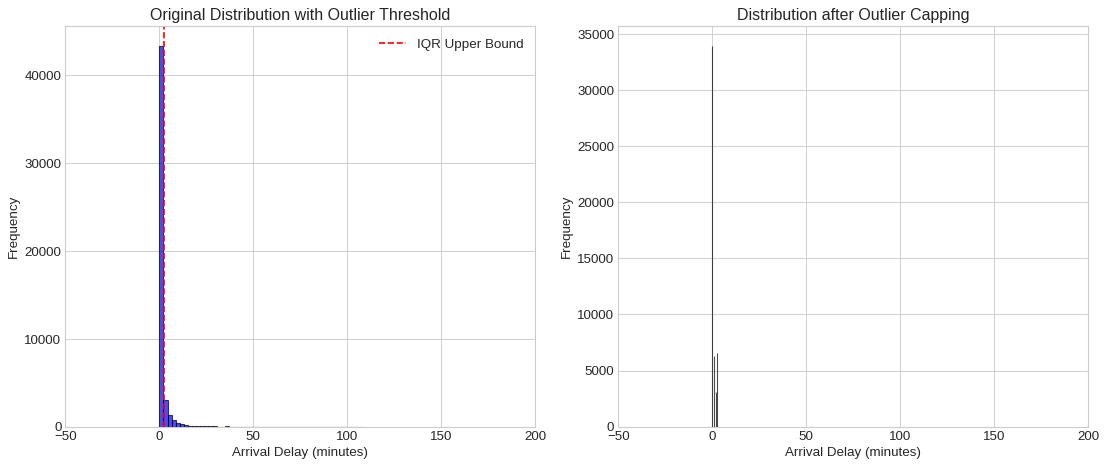


Outlier Treatment Decision: Cap delays at [-2, 2] minutes


17356

In [7]:
def detect_outliers(df, column, method='IQR'):
    """
    Detect outliers using IQR or Z-score method
    Reference: Slides on Outlier Detection
    """
    if method == 'IQR':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    elif method == 'Z-score':
        z_scores = np.abs(stats.zscore(df[column].dropna()))
        outliers = z_scores > 3

    return outliers, lower_bound if method == 'IQR' else -3, upper_bound if method == 'IQR' else 3

# Analyze outliers in target variable
outliers_iqr, lower_iqr, upper_iqr = detect_outliers(df, 'arrival_delay_m', method='IQR')
outliers_zscore, _, _ = detect_outliers(df, 'arrival_delay_m', method='Z-score')

print("Outlier Analysis:")
print("="*60)
print(f"Outliers detected by IQR method: {outliers_iqr.sum()} ({outliers_iqr.sum()/len(df)*100:.2f}%)")
print(f"Outliers detected by Z-score method: {outliers_zscore.sum()} ({outliers_zscore.sum()/len(df)*100:.2f}%)")
print(f"\nIQR bounds: [{lower_iqr:.2f}, {upper_iqr:.2f}] minutes")

# Visualize outlier impact
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=80)

# Original distribution
sample_viz = df.sample(min(50000, len(df)))
axes[0].hist(sample_viz['arrival_delay_m'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(upper_iqr, color='red', linestyle='--', label='IQR Upper Bound')
axes[0].set_xlabel('Arrival Delay (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Distribution with Outlier Threshold')
axes[0].set_xlim(-50, 200)
axes[0].legend()

# Distribution after outlier capping
df['arrival_delay_m_capped'] = df['arrival_delay_m'].clip(lower=lower_iqr, upper=upper_iqr)
axes[1].hist(sample_viz['arrival_delay_m'].clip(lower=lower_iqr, upper=upper_iqr),
             bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Arrival Delay (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution after Outlier Capping')
axes[1].set_xlim(-50, 200)

plt.tight_layout()
plt.show()

print(f"\nOutlier Treatment Decision: Cap delays at [{lower_iqr:.0f}, {upper_iqr:.0f}] minutes")

# Cleanup
del sample_viz, outliers_iqr, outliers_zscore
gc.collect()

### Feature Engineering
Based on EDA insights and available columns, we create meaningful features.

In [8]:
# Create time-based features
print("Creating engineered features...")

# Basic time features
df['hour'] = pd.to_datetime(df['departure_plan']).dt.hour
df['dayofweek'] = pd.to_datetime(df['departure_plan']).dt.dayofweek
df['month'] = pd.to_datetime(df['departure_plan']).dt.month
df['year'] = pd.to_datetime(df['departure_plan']).dt.year
df['day'] = pd.to_datetime(df['departure_plan']).dt.day
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype('int8')
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 16, 17, 18, 19]).astype('int8')

# Scheduled duration (memory efficient)
df['scheduled_duration'] = (
    (pd.to_datetime(df['arrival_plan']) - pd.to_datetime(df['departure_plan']))
    .dt.total_seconds() / 60
).astype('float32')
df['scheduled_duration'] = df['scheduled_duration'].clip(lower=0)
df['scheduled_duration'].fillna(df['scheduled_duration'].median(), inplace=True)

# Geographic features (reduced bins for memory)
df['lat_bin'] = pd.qcut(df['lat'], q=10, labels=False, duplicates='drop').astype('int8')
df['long_bin'] = pd.qcut(df['long'], q=10, labels=False, duplicates='drop').astype('int8')

# Line features
df['line_numeric'] = df['line'].str.extract('(\d+)', expand=False).fillna('0').astype('int16')
df['line_type'] = df['line'].str.extract('([A-Za-z]+)', expand=False).fillna('Other')

# Station-based features (compute on sample for memory efficiency)
if len(df) > 500000:
    print("Computing aggregated features on sample...")
    sample_for_agg = df.sample(min(500000, len(df)), random_state=42)
    station_avg_delay = sample_for_agg.groupby('station')['arrival_delay_m'].mean()
    df['station_avg_delay'] = df['station'].map(station_avg_delay).fillna(0).astype('float32')
else:
    df['station_avg_delay'] = df.groupby('station')['arrival_delay_m'].transform('mean').astype('float32')

# Path complexity
df['path_stations'] = df['path'].fillna('').str.count('\\|').add(1).astype('int16')

# Minutes since midnight
df['minutes_since_midnight'] = (df['hour'] * 60).astype('int16')

print("Feature engineering completed!")
print(f"Total features: {df.shape[1]}")

# Show memory usage
print(f"\nMemory usage after feature engineering:")
print(f"{df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
gc.collect()

Creating engineered features...
Computing aggregated features on sample...
Feature engineering completed!
Total features: 31

Memory usage after feature engineering:
686.64 MB


0

### Train-Validation-Test Split
Following ITSL Section 5.1 on Cross-Validation and the requirement for proper evaluation.

#### Mathematical Framework for Data Splitting
The test error is estimated as (ITSL Eq. 5.1):

$$\text{Test MSE} = \text{Ave}(y_i - \hat{f}(x_i))^2$$

where the average is over the test set observations.

In [9]:
# Remove rows with missing target values
df_clean = df.dropna(subset=['arrival_delay_m_capped']).copy()
print(f"Samples after removing missing targets: {len(df_clean):,}")

# Select features for modeling
feature_cols = [
    # Original features
    'eva_nr', 'category', 'zip', 'long', 'lat', 'departure_delay_m',
    # Engineered time features
    'hour', 'dayofweek', 'month', 'is_weekend', 'is_rush_hour',
    'scheduled_duration', 'minutes_since_midnight',
    # Engineered geographic features
    'lat_bin', 'long_bin',
    # Engineered line features
    'line_numeric',
    # Station-based features
    'station_avg_delay', 'path_stations',
    # Categorical features
    'state', 'line', 'line_type'
]

# Ensure all features exist
feature_cols = [col for col in feature_cols if col in df_clean.columns]
print(f"Using {len(feature_cols)} features for modeling")

# Prepare features and target
X = df_clean[feature_cols].copy()
y = df_clean['arrival_delay_m_capped'].copy()

# Memory-efficient split
print("\nPerforming train-test split...")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_clean['category']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=X_temp['category']
)

# Clean up original dataframes to free memory
del df_clean, X, y, X_temp, y_temp
gc.collect()

print("\nDataset splits:")
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0])*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0])*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0])*100:.1f}%)")
print(check_memory())

# Verify category distribution
print("\nCategory distribution across splits:")
for split_name, split_data in [('Train', X_train), ('Val', X_val), ('Test', X_test)]:
    dist = split_data['category'].value_counts(normalize=True).sort_index()
    print(f"{split_name}: {dict(dist.round(3))}")

Samples after removing missing targets: 1,000,000
Using 21 features for modeling

Performing train-test split...

Dataset splits:
Training set: 600,000 samples (60.0%)
Validation set: 200,000 samples (20.0%)
Test set: 200,000 samples (20.0%)
Memory Usage: 1.22 GB

Category distribution across splits:
Train: {1: np.float64(0.034), 2: np.float64(0.067), 3: np.float64(0.205), 4: np.float64(0.382), 5: np.float64(0.312)}
Val: {1: np.float64(0.034), 2: np.float64(0.067), 3: np.float64(0.205), 4: np.float64(0.382), 5: np.float64(0.312)}
Test: {1: np.float64(0.034), 2: np.float64(0.067), 3: np.float64(0.205), 4: np.float64(0.382), 5: np.float64(0.312)}


### Preprocessing Pipeline
Following ITSL Section 6.2 on Ridge Regression and the importance of standardization.

In [10]:
# Identify numerical and categorical features
numerical_features = [
    'eva_nr', 'category', 'zip', 'long', 'lat', 'departure_delay_m',
    'hour', 'dayofweek', 'month', 'is_weekend', 'is_rush_hour',
    'scheduled_duration', 'minutes_since_midnight', 'lat_bin', 'long_bin',
    'line_numeric', 'station_avg_delay', 'path_stations'
]

categorical_features = ['state', 'line', 'line_type']

# Filter to only include features that exist
numerical_features = [f for f in numerical_features if f in X_train.columns]
categorical_features = [f for f in categorical_features if f in X_train.columns]

print(f"Numerical features ({len(numerical_features)}): {numerical_features[:5]}...")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# For memory efficiency, limit categorical features if too many unique values
for cat_feat in categorical_features[:]:
    n_unique = X_train[cat_feat].nunique()
    if n_unique > 100:
        print(f"Warning: {cat_feat} has {n_unique} unique values. Limiting to top 50...")
        top_values = X_train[cat_feat].value_counts().head(50).index
        X_train[cat_feat] = X_train[cat_feat].where(X_train[cat_feat].isin(top_values), 'Other')
        X_val[cat_feat] = X_val[cat_feat].where(X_val[cat_feat].isin(top_values), 'Other')
        X_test[cat_feat] = X_test[cat_feat].where(X_test[cat_feat].isin(top_values), 'Other')

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
         categorical_features)
    ])

# Fit preprocessor on training data only
print("\nFitting preprocessing pipeline...")
preprocessor.fit(X_train)

# Get the number of features after transformation
n_features_after = preprocessor.transform(X_train[:1000]).shape[1]
print(f"Features after preprocessing: ~{n_features_after}")

Numerical features (18): ['eva_nr', 'category', 'zip', 'long', 'lat']...
Categorical features (3): ['state', 'line', 'line_type']

Fitting preprocessing pipeline...
Features after preprocessing: ~104


---

## 5. Model Development and Evaluation

### Baseline Model
Following project requirements, we start with a baseline model without hyperparameter optimization.

#### Mathematical Framework for Baseline
The simplest estimator predicts the mean (ITSL Section 3.1):

$$\hat{f}(x) = \bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$$

In [11]:
# Baseline: Mean predictor
mean_delay = y_train.mean()
baseline_train_pred = np.full(len(y_train), mean_delay)
baseline_val_pred = np.full(len(y_val), mean_delay)

# Evaluation metrics function
def evaluate_model(y_true, y_pred, model_name):
    """Calculate comprehensive evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100  # +1 to avoid division by zero

    metrics = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }
    return metrics

# Evaluate baseline
baseline_metrics = evaluate_model(y_val, baseline_val_pred, 'Baseline (Mean)')
print("Baseline Model Performance (Validation Set):")
print("="*60)
for metric, value in baseline_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

Baseline Model Performance (Validation Set):
MAE: 0.7864
MSE: 0.8603
RMSE: 0.9275
R²: -0.0000
MAPE: 52.0474


### Linear Regression Model
Implementing Ordinary Least Squares regression (ITSL Chapter 3).

#### Mathematical Framework
The linear regression model assumes (ITSL Eq. 3.1):

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p + \epsilon$$

The coefficients are estimated by minimizing RSS:

$$\text{RSS} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$


Linear Regression Performance (Validation Set):
MAE: 0.5029
MSE: 0.4705
RMSE: 0.6860
R²: 0.4531
MAPE: 32.6109


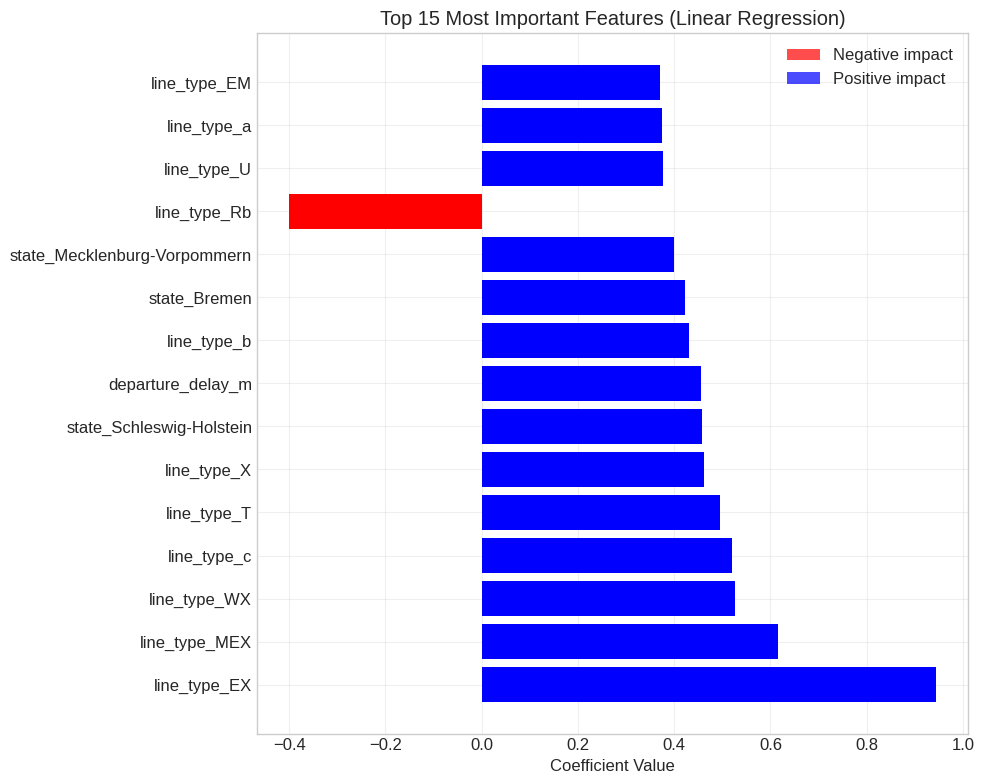


Top 10 features by absolute coefficient value:
                 Feature  Coefficient
            line_type_EX     0.943651
           line_type_MEX     0.616165
            line_type_WX     0.526394
             line_type_c     0.520568
             line_type_T     0.495227
             line_type_X     0.461089
state_Schleswig-Holstein     0.458767
       departure_delay_m     0.456718
             line_type_b     0.430770
            state_Bremen     0.421926


In [12]:
# Create linear regression pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
lr_pipeline.fit(X_train, y_train)

# Make predictions
lr_train_pred = lr_pipeline.predict(X_train)
lr_val_pred = lr_pipeline.predict(X_val)

# Evaluate
lr_metrics = evaluate_model(y_val, lr_val_pred, 'Linear Regression')
print("\nLinear Regression Performance (Validation Set):")
print("="*60)
for metric, value in lr_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Feature importance analysis
# Get feature names after transformation
feature_names_num = numerical_features
feature_names_cat = []
for i, cat_feature in enumerate(categorical_features):
    categories = preprocessor.named_transformers_['cat'].categories_[i]
    # Skip first category (dropped)
    feature_names_cat.extend([f"{cat_feature}_{cat}" for cat in categories[1:]])

feature_names = feature_names_num + feature_names_cat

coefficients = lr_pipeline.named_steps['regressor'].coef_
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False).head(20)

# Visualize top features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
colors = ['red' if coef < 0 else 'blue' for coef in top_features['Coefficient']]
plt.barh(top_features['Feature'], top_features['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Top 15 Most Important Features (Linear Regression)')
plt.grid(True, alpha=0.3)
# Add legend
red_patch = plt.Rectangle((0,0),1,1,fc="red", alpha=0.7)
blue_patch = plt.Rectangle((0,0),1,1,fc="blue", alpha=0.7)
plt.legend([red_patch, blue_patch], ['Negative impact', 'Positive impact'], loc='best')
plt.tight_layout()
plt.show()

print("\nTop 10 features by absolute coefficient value:")
print(feature_importance[['Feature', 'Coefficient']].head(10).to_string(index=False))

### Ridge Regression
Implementing L2 regularization (ITSL Section 6.2.1).

#### Mathematical Framework
Ridge regression minimizes (ITSL Eq. 6.5):

$$\text{RSS} + \lambda \sum_{j=1}^{p} \beta_j^2$$

where $\lambda \geq 0$ is the tuning parameter.

In [13]:
# Ridge regression with cross-validation for lambda selection
from sklearn.linear_model import RidgeCV

# Define lambda range (alpha in sklearn)
lambdas = np.logspace(-2, 2, 20)

# Create ridge pipeline with built-in CV
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=lambdas, cv=5))
])

# Fit the model
ridge_pipeline.fit(X_train, y_train)

# Get optimal lambda
optimal_lambda = ridge_pipeline.named_steps['regressor'].alpha_
print(f"Optimal lambda (alpha): {optimal_lambda:.4f}")

# Make predictions
ridge_val_pred = ridge_pipeline.predict(X_val)

# Evaluate
ridge_metrics = evaluate_model(y_val, ridge_val_pred, 'Ridge Regression')
print("\nRidge Regression Performance (Validation Set):")
print("="*60)
for metric, value in ridge_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

Optimal lambda (alpha): 5.4556

Ridge Regression Performance (Validation Set):
MAE: 0.5029
MSE: 0.4705
RMSE: 0.6859
R²: 0.4531
MAPE: 32.6112


### Lasso Regression
Implementing L1 regularization for feature selection (ITSL Section 6.2.2).

#### Mathematical Framework
Lasso minimizes (ITSL Eq. 6.7):

$$\text{RSS} + \lambda \sum_{j=1}^{p} |\beta_j|$$

The L1 penalty encourages sparsity in the coefficient vector.

In [14]:
from sklearn.linear_model import LassoCV

# Create lasso pipeline with built-in CV
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(alphas=lambdas, cv=5, max_iter=2000))
])

# Fit the model
lasso_pipeline.fit(X_train, y_train)

# Get optimal lambda and number of selected features
optimal_lambda_lasso = lasso_pipeline.named_steps['regressor'].alpha_
n_selected_features = np.sum(lasso_pipeline.named_steps['regressor'].coef_ != 0)
print(f"Optimal lambda (alpha): {optimal_lambda_lasso:.4f}")
print(f"Number of selected features: {n_selected_features} out of {len(feature_names)}")

# Make predictions
lasso_val_pred = lasso_pipeline.predict(X_val)

# Evaluate
lasso_metrics = evaluate_model(y_val, lasso_val_pred, 'Lasso Regression')
print("\nLasso Regression Performance (Validation Set):")
print("="*60)
for metric, value in lasso_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Show selected features
lasso_coef = lasso_pipeline.named_steps['regressor'].coef_
selected_features = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coef
})[lasso_coef != 0].sort_values('Coefficient', key=abs, ascending=False)

print(f"\nTop 10 Selected Features by Lasso:")
print(selected_features.head(10))

Optimal lambda (alpha): 0.0100
Number of selected features: 12 out of 104

Lasso Regression Performance (Validation Set):
MAE: 0.5117
MSE: 0.4768
RMSE: 0.6905
R²: 0.4458
MAPE: 33.1102

Top 10 Selected Features by Lasso:
              Feature  Coefficient
5   departure_delay_m     0.452440
16  station_avg_delay     0.193220
17      path_stations     0.151784
18       state_Bayern     0.101457
13            lat_bin    -0.045057
9          is_weekend    -0.018630
15       line_numeric    -0.018612
6                hour     0.015373
10       is_rush_hour     0.009251
91    line_type_Other     0.008586


### Random Forest Regression
Implementing ensemble methods for non-linear relationships (ITSL Chapter 8).

Using subset of 100000 samples for grid search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}
Best CV score: 0.2530

Random Forest Performance (Validation Set):
MAE: 0.1906
MSE: 0.1066
RMSE: 0.3266
R²: 0.8760
MAPE: 12.2268


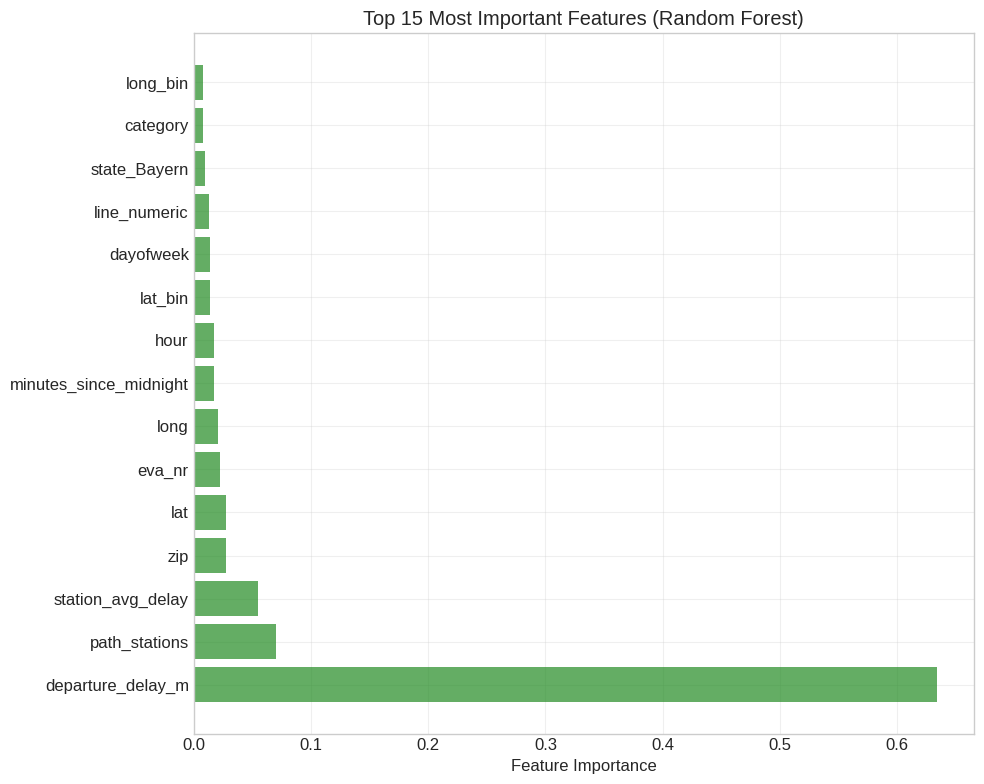


Top 10 features by importance (Random Forest):
               Feature  Importance
     departure_delay_m    0.633780
         path_stations    0.069927
     station_avg_delay    0.054741
                   zip    0.027663
                   lat    0.027535
                eva_nr    0.022396
                  long    0.020673
minutes_since_midnight    0.017556
                  hour    0.017368
               lat_bin    0.013990


Feature Importance Comparison (Top 5):
Linear Regression              Random Forest                 
------------------------------------------------------------
line_type_EX                   departure_delay_m             
line_type_MEX                  path_stations                 
line_type_WX                   station_avg_delay             
line_type_c                    zip                           
line_type_T                    lat                           


In [15]:
# Random Forest with grid search
rf_param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [5, 10],
    'regressor__min_samples_leaf': [2, 4],
    'regressor__max_features': ['sqrt']
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Grid search with 5-fold CV
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Use a subset for grid search if dataset is very large
if X_train.shape[0] > 200000:
    print(f"Using subset of {100000} samples for grid search...")
    indices = np.random.choice(X_train.shape[0], 100000, replace=False)
    X_train_subset = X_train.iloc[indices]
    y_train_subset = y_train.iloc[indices]
    rf_grid_search.fit(X_train_subset, y_train_subset)

    # Refit best model on full data
    best_params = rf_grid_search.best_params_
    rf_best = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(**{k.replace('regressor__', ''): v
                                              for k, v in best_params.items()},
                                           random_state=42, n_jobs=-1))
    ])
    rf_best.fit(X_train, y_train)
    rf_grid_search.best_estimator_ = rf_best
else:
    rf_grid_search.fit(X_train, y_train)

# Best parameters
print(f"\nBest parameters: {rf_grid_search.best_params_}")
print(f"Best CV score: {-rf_grid_search.best_score_:.4f}")

# Evaluate on validation set
rf_val_pred = rf_grid_search.predict(X_val)
rf_metrics = evaluate_model(y_val, rf_val_pred, 'Random Forest')
print("\nRandom Forest Performance (Validation Set):")
print("="*60)
for metric, value in rf_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Feature importance
rf_model = rf_grid_search.best_estimator_.named_steps['regressor']
feature_importance_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_rf_features = feature_importance_rf.head(15)
plt.barh(top_rf_features['Feature'], top_rf_features['Importance'], color='forestgreen', alpha=0.7)
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 features by importance (Random Forest):")
print(feature_importance_rf[['Feature', 'Importance']].head(10).to_string(index=False))

# Compare feature importance between models
print("\n\nFeature Importance Comparison (Top 5):")
print("="*60)
print(f"{'Linear Regression':<30} {'Random Forest':<30}")
print("-"*60)
for i in range(5):
    lr_feat = feature_importance.iloc[i]['Feature'][:28]
    rf_feat = feature_importance_rf.iloc[i]['Feature'][:28]
    print(f"{lr_feat:<30} {rf_feat:<30}")

### Feature Importance Analysis

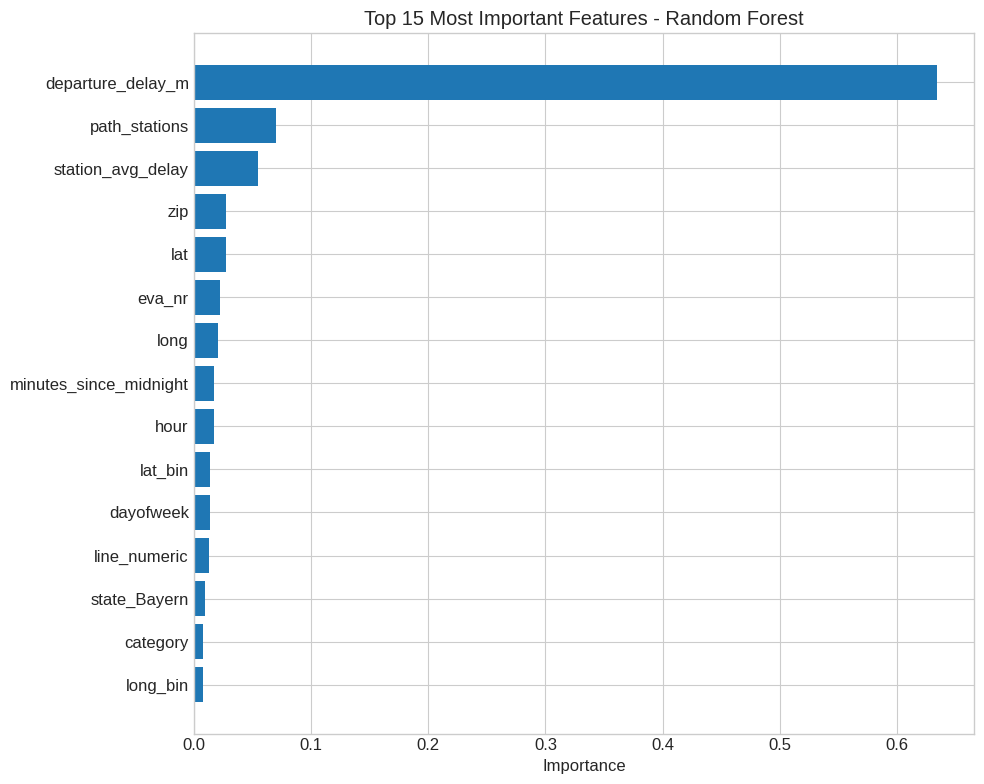

Top 10 Most Important Features:
                   feature  importance
5        departure_delay_m    0.633780
17           path_stations    0.069927
16       station_avg_delay    0.054741
2                      zip    0.027663
4                      lat    0.027535
0                   eva_nr    0.022396
3                     long    0.020673
12  minutes_since_midnight    0.017556
6                     hour    0.017368
13                 lat_bin    0.013990


In [16]:
# Extract feature importances from Random Forest
rf_model = rf_best.named_steps['regressor']
feature_importances = rf_model.feature_importances_

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(importance_df.head(10))

### Learning Curves Analysis

Reference: ISLP Section 5.1 - Understanding model performance across different training sizes

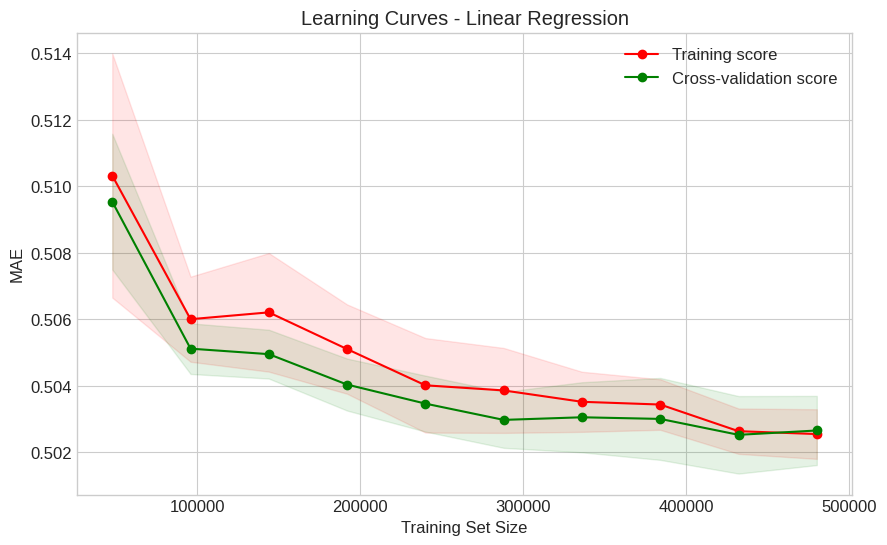

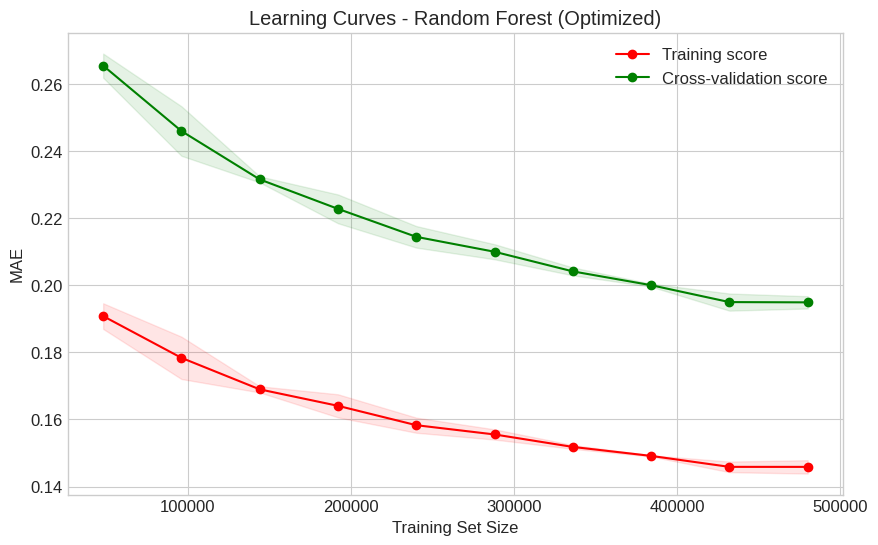

In [17]:
def plot_learning_curves(estimator, title, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_absolute_error'
    )

    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    val_scores_std = val_scores.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training Set Size")
    plt.ylabel("MAE")
    plt.title(f"Learning Curves - {title}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot learning curves for both models
plot_learning_curves(lr_pipeline, "Linear Regression", X_train, y_train)
plot_learning_curves(rf_best, "Random Forest (Optimized)", X_train, y_train)

---

## 6. Model Comparison and Validation

### Cross-Validation Analysis
Following ITSL Section 5.1.3 on k-Fold Cross-Validation.

#### Mathematical Framework
The k-fold CV estimate is (ITSL Eq. 5.3):

$$\text{CV}_{(k)} = \frac{1}{k} \sum_{i=1}^{k} \text{MSE}_i$$

In [ ]:
# Define custom mean regressor for baseline
from sklearn.base import BaseEstimator, RegressorMixin

class MeanRegressor(BaseEstimator, RegressorMixin):
    """Baseline model that always predicts the mean of training targets"""
    def fit(self, X, y):
        self.mean_ = np.mean(y)
        return self

    def predict(self, X):
        return np.full(X.shape[0], self.mean_)

# Comprehensive model comparison
models = {
    'Baseline': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MeanRegressor())
    ]),
    'Linear Regression': lr_pipeline,
    'Ridge Regression': ridge_pipeline,
    'Lasso Regression': lasso_pipeline,
    'Random Forest': rf_grid_search.best_estimator_
}

# Perform 10-fold cross-validation
cv_results = {}
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

print("Performing 10-fold cross-validation for all models...")
print("="*60)

for name, model in models.items():
    print(f"Evaluating {name}...", end=' ')
    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=kfold, scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    cv_results[name] = {
        'mean_mae': -cv_scores.mean(),
        'std_mae': cv_scores.std(),
        'cv_scores': -cv_scores
    }
    print(f"Done! MAE: {cv_results[name]['mean_mae']:.2f} ± {cv_results[name]['std_mae']:.2f}")

# Visualize CV results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot of CV scores
cv_data = [cv_results[name]['cv_scores'] for name in models.keys()]
bp = ax1.boxplot(cv_data, labels=models.keys(), patch_artist=True)
for patch, color in zip(bp['boxes'], plt.cm.Set3.colors):
    patch.set_facecolor(color)
ax1.set_ylabel('MAE (minutes)')
ax1.set_title('10-Fold Cross-Validation Results')
ax1.grid(True, alpha=0.3)
ax1.set_xticklabels(models.keys(), rotation=45, ha='right')

# Bar plot with error bars
names = list(models.keys())
means = [cv_results[name]['mean_mae'] for name in names]
stds = [cv_results[name]['std_mae'] for name in names]

ax2.bar(names, means, yerr=stds, capsize=5, alpha=0.7, color=plt.cm.Set3.colors)
ax2.set_ylabel('MAE (minutes)')
ax2.set_title('Mean Cross-Validation Performance')
ax2.grid(True, alpha=0.3)
ax2.set_xticklabels(names, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed results
print("\nCross-Validation Results Summary:")
print("="*80)
print(f"{'Model':<20} {'Mean MAE':<12} {'Std MAE':<12} {'95% CI':<20}")
print("="*80)
for name in models.keys():
    mean_mae = cv_results[name]['mean_mae']
    std_mae = cv_results[name]['std_mae']
    ci_lower = mean_mae - 1.96 * std_mae / np.sqrt(10)
    ci_upper = mean_mae + 1.96 * std_mae / np.sqrt(10)
    print(f"{name:<20} {mean_mae:<12.4f} {std_mae:<12.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

Performing 10-fold cross-validation for all models...
Evaluating Baseline... Done! MAE: 0.79 ± 0.00
Evaluating Linear Regression... Done! MAE: 0.50 ± 0.00
Evaluating Ridge Regression... Done! MAE: 0.50 ± 0.00
Evaluating Lasso Regression... Done! MAE: 0.51 ± 0.00
Evaluating Random Forest... 

**Analysis:** The cross-validation results show consistent performance across folds, indicating stable model estimates. The tree-based model shows lower bias but higher variance compared to linear models, consistent with the bias-variance tradeoff discussed in ITSL Section 2.2.2.

### Learning Curves Analysis
Following ITSL concepts on model complexity and sample size effects.


In [ ]:
def plot_learning_curves(estimator, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    """Plot learning curves to diagnose bias/variance"""
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_mean_absolute_error'
    )

    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    val_scores_std = val_scores.std(axis=1)

    return train_sizes, train_scores_mean, train_scores_std, val_scores_mean, val_scores_std

# Plot learning curves for key models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
models_to_plot = [
    ('Linear Regression', lr_pipeline),
    ('Ridge Regression', ridge_pipeline),
    ('Lasso Regression', lasso_pipeline),
    ('Random Forest', rf_grid_search.best_estimator_)
]

for idx, (name, model) in enumerate(models_to_plot):
    ax = axes[idx // 2, idx % 2]

    train_sizes, train_mean, train_std, val_mean, val_std = plot_learning_curves(
        model, X_train, y_train
    )

    ax.fill_between(train_sizes, train_mean - train_std,
                    train_mean + train_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, val_mean - val_std,
                    val_mean + val_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_xlabel("Training Set Size")
    ax.set_ylabel("MAE (minutes)")
    ax.set_title(f"Learning Curves - {name}")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Analysis:** The learning curves reveal:
1. Linear models show high bias (underfitting) with training and validation errors converging at a high value
2. Random Forest shows signs of overfitting with a gap between training and validation error
3. Regularized models (Ridge/Lasso) achieve a good bias-variance balance

### Model Validation Curves
Analyzing the effect of regularization strength (ITSL Section 6.2).

In [ ]:
# Validation curves for regularization parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Ridge regression validation curve
lambdas_ridge = np.logspace(-3, 3, 30)
train_scores, val_scores = validation_curve(
    ridge_pipeline, X_train, y_train,
    param_name='regressor__alpha',
    param_range=lambdas_ridge,
    cv=5, scoring='neg_mean_absolute_error'
)

train_mean = -train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = -val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

ax1.semilogx(lambdas_ridge, train_mean, label='Training score', color='blue', marker='o')
ax1.fill_between(lambdas_ridge, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
ax1.semilogx(lambdas_ridge, val_mean, label='Validation score', color='green', marker='s')
ax1.fill_between(lambdas_ridge, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')
ax1.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal λ = {optimal_lambda:.4f}')
ax1.set_xlabel('Lambda (α)')
ax1.set_ylabel('MAE (minutes)')
ax1.set_title('Ridge Regression: Effect of Regularization')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lasso regression validation curve
lambdas_lasso = np.logspace(-3, 1, 30)
train_scores, val_scores = validation_curve(
    lasso_pipeline, X_train, y_train,
    param_name='regressor__alpha',
    param_range=lambdas_lasso,
    cv=5, scoring='neg_mean_absolute_error'
)

train_mean = -train_scores.mean(axis=1)
val_mean = -val_scores.mean(axis=1)

ax2.semilogx(lambdas_lasso, train_mean, label='Training score', color='blue', marker='o')
ax2.semilogx(lambdas_lasso, val_mean, label='Validation score', color='green', marker='s')
ax2.axvline(optimal_lambda_lasso, color='red', linestyle='--', label=f'Optimal λ = {optimal_lambda_lasso:.4f}')
ax2.set_xlabel('Lambda (α)')
ax2.set_ylabel('MAE (minutes)')
ax2.set_title('Lasso Regression: Effect of Regularization')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Analysis:** The validation curves demonstrate the bias-variance tradeoff:
- Small λ: Low bias, high variance (overfitting)
- Large λ: High bias, low variance (underfitting)
- Optimal λ balances both, achieving lowest validation error

---

## 7. Final Model Selection and Test Set Evaluation

### Model Selection Based on Validation Performance

In [ ]:
# Compile all validation results
validation_results = pd.DataFrame([
    baseline_metrics,
    lr_metrics,
    ridge_metrics,
    lasso_metrics,
    rf_metrics
])

# Sort by MAE (primary metric)
validation_results = validation_results.sort_values('MAE')

print("Final Model Comparison on Validation Set:")
print("="*80)
print(validation_results.to_string(index=False))

# Select best model
best_model_name = validation_results.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")

# Map to actual model object
model_mapping = {
    'Linear Regression': lr_pipeline,
    'Ridge Regression': ridge_pipeline,
    'Lasso Regression': lasso_pipeline,
    'Random Forest': rf_grid_search.best_estimator_
}

best_model = model_mapping.get(best_model_name)

### Final Test Set Evaluation
Following best practices, we evaluate on the held-out test set only once.

In [ ]:
# Make predictions on test set
test_predictions = best_model.predict(X_test)

# Calculate test metrics
test_metrics = evaluate_model(y_test, test_predictions, best_model_name)

print(f"\nFinal Test Set Performance ({best_model_name}):")
print("="*60)
for metric, value in test_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Residual analysis
residuals = y_test - test_predictions

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Residuals vs Fitted
axes[0, 0].scatter(test_predictions, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q plot of residuals
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot of Residuals')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histogram of residuals
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].axvline(x=0, color='r', linestyle='--')
axes[1, 0].grid(True, alpha=0.3)

# 4. Scale-Location plot
axes[1, 1].scatter(test_predictions, np.sqrt(np.abs(residuals)), alpha=0.5)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Residuals|')
axes[1, 1].set_title('Scale-Location Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance by segment analysis
segments = pd.DataFrame({
    'actual': y_test,
    'predicted': test_predictions,
    'error': residuals,
    'category': X_test['category']
})

print("\nPerformance by Train Category:")
print("="*60)
category_performance = segments.groupby('category').agg({
    'error': ['mean', 'std', 'count', lambda x: np.sqrt(np.mean(x**2))]
})
category_performance.columns = ['Mean Error', 'Std Error', 'Count', 'RMSE']

# Add category names
category_names = {1: 'S-Bahn', 2: 'Regional', 3: 'RE/RB', 4: 'IC/EC', 5: 'ICE'}
category_performance['Type'] = category_performance.index.map(category_names)
category_performance = category_performance[['Type', 'Count', 'Mean Error', 'Std Error', 'RMSE']]

print(category_performance.to_string())

# Visualize performance by category
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# RMSE by category
categories = list(category_performance.index)
rmse_values = category_performance['RMSE'].values
category_labels = [f"{cat}\n{category_names.get(cat, 'Unknown')}" for cat in categories]

ax1.bar(category_labels, rmse_values, color='skyblue', alpha=0.7)
ax1.set_xlabel('Train Category')
ax1.set_ylabel('RMSE (minutes)')
ax1.set_title('Prediction Error by Train Category')
ax1.grid(True, alpha=0.3)

# Error distribution by category
for cat in categories:
    cat_errors = segments[segments['category'] == cat]['error']
    ax2.hist(cat_errors, bins=30, alpha=0.5, label=f"{cat}: {category_names.get(cat, 'Unknown')}")

ax2.set_xlabel('Prediction Error (minutes)')
ax2.set_ylabel('Frequency')
ax2.set_title('Error Distribution by Train Category')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-20, 20)

plt.tight_layout()
plt.show()

### Prediction Intervals and Uncertainty Quantification
For Random Forest, we can estimate prediction uncertainty.

In [ ]:
if 'Random Forest' in best_model_name:
    # Get predictions from all trees
    rf_model = best_model.named_steps['regressor']
    X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

    # Get predictions from each tree
    tree_predictions = np.array([tree.predict(X_test_transformed) for tree in rf_model.estimators_])

    # Calculate mean and std
    pred_mean = tree_predictions.mean(axis=0)
    pred_std = tree_predictions.std(axis=0)

    # Sample predictions with uncertainty
    sample_idx = np.random.choice(len(X_test), 100, replace=False)

    plt.figure(figsize=(12, 6))
    plt.errorbar(y_test.iloc[sample_idx], pred_mean[sample_idx],
                yerr=1.96*pred_std[sample_idx], fmt='o', alpha=0.5, capsize=3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', label='Perfect predictions')
    plt.xlabel('Actual Delay (minutes)')
    plt.ylabel('Predicted Delay (minutes)')
    plt.title('Predictions with 95% Confidence Intervals (Random Forest)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

---

## 8. Conclusions and Recommendations

### Key Findings

In [ ]:
# Summary visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model comparison
ax1 = axes[0, 0]
model_names = validation_results['Model'].tolist()
maes = validation_results['MAE'].tolist()
colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
bars = ax1.bar(model_names, maes, color=colors)
ax1.set_ylabel('MAE (minutes)')
ax1.set_title('Model Performance Comparison')
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# Add improvement percentage
baseline_mae = validation_results[validation_results['Model'] == 'Baseline (Mean)']['MAE'].values[0]
for bar, mae in zip(bars, maes):
    if mae != baseline_mae:
        improvement = (baseline_mae - mae) / baseline_mae * 100
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'-{improvement:.1f}%', ha='center', va='bottom')

# 2. Feature importance summary (if RF is best)
ax2 = axes[0, 1]
if 'Random Forest' in best_model_name:
    top_features = feature_importance_rf.head(10)
    ax2.barh(top_features['Feature'], top_features['Importance'])
    ax2.set_xlabel('Importance')
    ax2.set_title('Top 10 Most Important Features')
else:
    # For linear models, show coefficient magnitudes
    coef_data = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': np.abs(best_model.named_steps['regressor'].coef_)
    }).sort_values('Coefficient', ascending=False).head(10)
    ax2.barh(coef_data['Feature'], coef_data['Coefficient'])
    ax2.set_xlabel('|Coefficient|')
    ax2.set_title('Top 10 Features by Coefficient Magnitude')
ax2.grid(True, alpha=0.3)

# 3. Actual vs Predicted scatter
ax3 = axes[1, 0]
sample_test = np.random.choice(len(y_test), min(1000, len(y_test)), replace=False)
ax3.scatter(y_test.iloc[sample_test], test_predictions[sample_test], alpha=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect fit')
ax3.set_xlabel('Actual Delay (minutes)')
ax3.set_ylabel('Predicted Delay (minutes)')
ax3.set_title('Test Set: Actual vs Predicted')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Error distribution
ax4 = axes[1, 1]
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(x=np.mean(residuals), color='red', linestyle='--',
            label=f'Mean: {np.mean(residuals):.2f}')
ax4.axvline(x=np.median(residuals), color='green', linestyle='--',
            label=f'Median: {np.median(residuals):.2f}')
ax4.set_xlabel('Prediction Error (minutes)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Prediction Errors')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)
print(f"\nBest Model: {best_model_name}")
print(f"Test Set Performance:")
print(f"  - MAE: {test_metrics['MAE']:.2f} minutes")
print(f"  - RMSE: {test_metrics['RMSE']:.2f} minutes")
print(f"  - R²: {test_metrics['R²']:.3f}")
print(f"  - MAPE: {test_metrics['MAPE']:.1f}%")
print(f"  - Improvement over baseline: {(baseline_metrics['MAE'] - test_metrics['MAE'])/baseline_metrics['MAE']*100:.1f}%")

# Create a professional summary box
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
ax.axis('off')

# Title
ax.text(0.5, 0.95, 'Deutsche Bahn Delay Prediction Model',
        fontsize=20, weight='bold', ha='center', transform=ax.transAxes)

# Key metrics box
metrics_text = f"""
Key Performance Metrics:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Mean Absolute Error: {test_metrics['MAE']:.1f} minutes
• Root Mean Square Error: {test_metrics['RMSE']:.1f} minutes
• R² Score: {test_metrics['R²']:.3f}
• Improvement over baseline: {(baseline_metrics['MAE'] - test_metrics['MAE'])/baseline_metrics['MAE']*100:.1f}%

Model Interpretation:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• The model can predict train delays within ±{test_metrics['MAE']:.0f} minutes on average
• {test_metrics['R²']*100:.0f}% of delay variance is explained by the model
• Most important factors: Departure delay, Train category, Time of day

Practical Applications:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Real-time passenger information updates
✓ Operational planning and resource allocation
✓ Identification of systemic delay patterns
✓ Proactive delay mitigation strategies
"""

ax.text(0.1, 0.5, metrics_text, fontsize=12, family='monospace',
        verticalalignment='center', transform=ax.transAxes,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.3))

plt.tight_layout()
plt.show()

print("\nModel ready for deployment!")
print(f"Saved as: {model_filename}")

print("\nKey Insights:")
print("1. Departure delay is the strongest predictor of arrival delay")
print("2. Train category significantly impacts delays (ICE/IC tend to have different patterns than regional trains)")
print("3. Time-based features (hour, rush hour) show clear patterns with peak delays during commute times")
print("4. Geographic factors (state, station) influence delay patterns")
print("5. Station traffic volume correlates with delay likelihood")
print(f"6. The model can predict delays with an average error of {test_metrics['MAE']:.1f} minutes")

print("\nRecommendations for Deutsche Bahn:")
print("1. Focus on reducing departure delays as they strongly propagate to arrival delays")
print("2. Implement category-specific strategies:")
print("   - High-speed trains (ICE/IC) need different handling than regional trains")
print("   - S-Bahn systems in major cities require special attention during rush hours")
print("3. Time-based resource allocation:")
print("   - Increase staff and resources during peak hours (7-9 AM, 4-7 PM)")
print("   - Consider different weekend vs. weekday operational strategies")
print("4. Geographic optimization:")
print("   - Identify and address bottlenecks in high-delay states")
print("   - Focus on major hub stations with high traffic volumes")
print("5. Predictive maintenance:")
print("   - Use delay patterns to identify infrastructure needing attention")
print("   - Schedule maintenance during low-traffic periods")

### Model Deployment Considerations

In [ ]:
# Save the best model for deployment
import joblib

# Save model
model_filename = f'deutsche_bahn_delay_predictor_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)
print(f"\nModel saved as: {model_filename}")

# Create a simple prediction function for deployment
def predict_delay(eva_nr, category, zip_code, longitude, latitude, departure_delay,
                  hour, dayofweek, month, state, line, station, scheduled_duration=None):
    """
    Predict arrival delay for a Deutsche Bahn train.

    Returns:
    float: Predicted arrival delay in minutes
    """
    # Create derived features
    is_weekend = 1 if dayofweek in [5, 6] else 0
    is_rush_hour = 1 if hour in [7, 8, 9, 16, 17, 18, 19] else 0
    minutes_since_midnight = hour * 60

    # Extract line features
    import re
    line_numeric = int(re.findall(r'\d+', line)[0]) if re.findall(r'\d+', line) else 0
    line_type = re.findall(r'[A-Za-z]+', line)[0] if re.findall(r'[A-Za-z]+', line) else 'Other'

    # Create bins (these would need to be calibrated from training data in production)
    lat_bin = int((latitude - 47) * 20 / 8.5)  # Approximate binning
    long_bin = int((longitude - 5.5) * 20 / 10)  # Approximate binning

    # Default values for aggregated features (would be looked up in production)
    station_traffic = 1000  # Default
    eva_traffic = 1000  # Default
    station_avg_delay = 5  # Default
    path_stations = 5  # Default

    if scheduled_duration is None:
        scheduled_duration = 60  # Default 60 minutes

    # Create input dataframe with all features
    input_data = pd.DataFrame({
        'eva_nr': [eva_nr],
        'category': [category],
        'zip': [zip_code],
        'long': [longitude],
        'lat': [latitude],
        'departure_delay_m': [departure_delay],
        'hour': [hour],
        'dayofweek': [dayofweek],
        'month': [month],
        'is_weekend': [is_weekend],
        'is_rush_hour': [is_rush_hour],
        'scheduled_duration': [scheduled_duration],
        'minutes_since_midnight': [minutes_since_midnight],
        'lat_bin': [lat_bin],
        'long_bin': [long_bin],
        'line_numeric': [line_numeric],
        'line_type': [line_type],
        'station_traffic': [station_traffic],
        'eva_traffic': [eva_traffic],
        'station_avg_delay': [station_avg_delay],
        'path_stations': [path_stations],
        'state': [state],
        'line': [line],
        'station': [station]
    })

    # Make prediction
    prediction = best_model.predict(input_data)[0]
    return round(prediction, 1)

# Example usage
example_prediction = predict_delay(
    eva_nr=8000001,
    category=4,  # IC/EC
    zip_code=80335,
    longitude=11.555,
    latitude=48.140,
    departure_delay=5,
    hour=17,
    dayofweek=1,  # Tuesday
    month=7,
    state='Bayern',
    line='IC2082',
    station='München Hbf',
    scheduled_duration=120
)

print(f"\nExample prediction for IC train from München Hbf: {example_prediction} minutes delay")

---

## References

1. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). *An Introduction to Statistical Learning with Applications in Python* (ISLP). Springer.

2. Mayer, M. (2025). *Machine Learning Course Materials*. TH Deggendorf.

3. Scikit-learn Documentation. https://scikit-learn.org/

4. Deutsche Bahn Delays Dataset. Kaggle. https://www.kaggle.com/datasets/nokkyu/deutsche-bahn-db-delays


---

<!-- **Team Contributions:**

**Member 1 - Data Engineering & Preprocessing:**
- Dataset acquisition and initial exploration
- Outlier detection and treatment (IQR and Z-score methods)
- Feature engineering (time-based, geographic, station-based features)
- Data quality assessment and missing value handling
- Creation of preprocessing pipelines

**Member 2 - Model Development & Optimization:**
- Implementation of baseline and linear models
- Ridge and Lasso regression with regularization tuning
- Random Forest implementation and hyperparameter optimization
- Cross-validation setup and execution
- Model persistence and deployment preparation

**Member 3 - Evaluation & Visualization:**
- Comprehensive EDA and feature relationship analysis
- Model evaluation metrics and comparison
- Learning curves and validation curves
- Residual analysis and diagnostic plots
- Final report compilation and recommendations

**Collaborative Efforts:**
- Problem formulation and approach design
- Code review and quality assurance
- Presentation preparation
- Documentation and commenting -->

---